In [1]:
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et 

# VEST GA '18


## Load in Files

### VEST File

In [2]:
vest_ga_18 = gp.read_file("./raw-from-source/VEST/ga_2018/ga_2018.shp")

### VEST Data Documentation

Election results from the Georgia Secretary of State Elections Division  
- https://sos.ga.gov/index.php/Elections/current_and_past_elections_results  

Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office  
- http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx

### Precinct Shapefile

In [3]:
precincts_ga = gp.read_file("./raw-from-source/GA_shapefile/vtd2018-shapefile/VTD2018-Shapefile.shp")

### Election Results (General) 

In [4]:
loaded_counties = os.listdir("./raw-from-source/Election_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Election_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        #county = county_area.attrib.get('text')
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
                        #print(x)
                    #print("")
                #print("")
            #print("")
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df = pd.DataFrame(z,columns=dfcols)
df["num_votes"]=df["num_votes"].astype(int)
office_list = ['Governor', 'Lieutenant Governor', 'Secretary Of State','Attorney General', 'Commissioner Of Agriculture','Commissioner Of Insurance','State School Superintendent','Commissioner Of Labor','Public Service Commission, District 3 - Metro-Atlanta','Public Service Commission, District 5 - Western']
df = df[df["contest"].isin(office_list)]
df["precinct"]=df["precinct"].str.upper()

#### Confirm that totals match VEST

In [5]:
print(sum(df["num_votes"]))

vest_list = ['G18GOVRKEM', 'G18GOVDABR',
       'G18GOVLMET', 'G18LTGRDUN', 'G18LTGDAMI', 'G18SOSRRAF', 'G18SOSDBAR',
       'G18SOSLDUV', 'G18ATGRCAR', 'G18ATGDBAI', 'G18AGRRBLA', 'G18AGRDSWA',
       'G18INSRBEC', 'G18INSDLAW', 'G18INSLFOS', 'G18SPIRWOO', 'G18SPIDTHO',
       'G18LABRBUT', 'G18LABDKEA', 'G18PSCREAT', 'G18PSCDMIL', 'G18PSCLGRA',
       'G18PSCRPRI', 'G18PSCDRAN', 'G18PSCLTUR']
total = 0
for i in vest_list:
    total += sum(vest_ga_18[i])
print(total)

38596839
38596839


#### FIPS Dictionary

In [6]:
fips_file = pd.read_csv("./US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Georgia"]
fips_file["FIPS County"] = fips_file["FIPS County"].astype(str)
fips_file["FIPS County"] = fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"] = fips_file["County Name"].replace("De Kalb","DeKalb")
fips_dict = dict(zip(fips_file['County Name'], fips_file['FIPS County']))


#### Clean and pivot results

In [7]:
df['county_fips'] = df['county'].map(fips_dict).fillna(df['county'])
df['county_fips'] = df['county_fips'].astype(str)
df['county_fips'] = df['county_fips'].str.zfill(3)
df["unique_ID"]=df["county_fips"]+df["precinct"]
df=pd.pivot_table(df,index=["unique_ID","county","county_fips","precinct"],columns=["choice"],values=['num_votes'],aggfunc=sum)
df = df.fillna(0)
df.columns = df.columns.droplevel(0)
df = df.reset_index()
df["TED METZ (LIB)"]+=df["T. METZ (L)"]
df = df.drop(["T. METZ (L)"], axis=1)
df = df.rename(columns={'BRAD RAFFENSPERGER  (REP)':"G18SOSRRAF",'BRIAN KEMP  (REP)':"G18GOVRKEM",'CHARLIE BAILEY  (DEM)': "G18ATGDBAI",'CHRIS CARR (I) (REP)':"G18ATGRCAR",'CHUCK EATON (I) (REP)':"G18PSCREAT",'DAWN A. RANDOLPH (DEM)':"G18PSCDRAN",'DONNIE FOSTER (LIB)':"G18INSLFOS",'FRED SWANN  (DEM)':"G18AGRDSWA",'GARY BLACK (I) (REP)':"G18AGRRBLA",'GEOFF DUNCAN  (REP)':"G18LTGRDUN",'JANICE LAWS  (DEM)':"G18INSDLAW",'JIM BECK  (REP)':"G18INSRBEC",'JOHN BARROW  (DEM)':"G18SOSDBAR",'JOHN TURPISH (LIB)':"G18PSCLTUR",'LINDY MILLER (DEM)':"G18PSCDMIL",'MARK BUTLER (I) (REP)':"G18LABRBUT",'OTHA E. THORNTON, JR (DEM)':"G18SPIDTHO",'RICHARD KEATLEY (DEM)':"G18LABDKEA",'RICHARD WOODS (I) (REP)':"G18SPIRWOO",'RYAN GRAHAM (LIB)':"G18PSCLGRA",'SARAH RIGGS AMICO (DEM)':"G18LTGDAMI",'SMYTHE DUVAL (LIB)':"G18SOSLDUV",'STACEY ABRAMS  (DEM)':"G18GOVDABR",'TED METZ (LIB)':"G18GOVLMET",'TRICIA PRIDEMORE (I) (REP)':"G18PSCRPRI"})
print(df.head())

choice unique_ID   county county_fips precinct  G18SOSRRAF  G18GOVRKEM  \
0          0011B  Appling         001       1B       614.0       701.0   
1          0011C  Appling         001       1C       426.0       498.0   
2           0012  Appling         001        2       359.0       399.0   
3         0013A1  Appling         001      3A1       480.0       519.0   
4          0013C  Appling         001       3C       643.0       727.0   

choice  G18ATGDBAI  G18ATGRCAR  G18PSCREAT  G18PSCDRAN  ...  G18LABRBUT  \
0             93.0       663.0       650.0        88.0  ...       663.0   
1             48.0       466.0       475.0        41.0  ...       484.0   
2            711.0       400.0       397.0       709.0  ...       418.0   
3             23.0       501.0       501.0        26.0  ...       501.0   
4            205.0       694.0       690.0       194.0  ...       710.0   

choice  G18SPIDTHO  G18LABDKEA  G18SPIRWOO  G18PSCLGRA  G18LTGDAMI  \
0             80.0        89.0    

#### Check that totals still match

In [8]:
col_list = ['G18GOVRKEM', 'G18GOVDABR','G18GOVLMET', 'G18LTGRDUN', 'G18LTGDAMI', 'G18SOSRRAF', 'G18SOSDBAR',
       'G18SOSLDUV', 'G18ATGRCAR', 'G18ATGDBAI', 'G18AGRRBLA', 'G18AGRDSWA','G18INSRBEC', 'G18INSDLAW', 'G18INSLFOS', 'G18SPIRWOO', 'G18SPIDTHO',
       'G18LABRBUT', 'G18LABDKEA', 'G18PSCREAT', 'G18PSCDMIL', 'G18PSCLGRA','G18PSCRPRI', 'G18PSCDRAN', 'G18PSCLTUR']
total = 0
for i in col_list:
    total += sum(df[i])
print(total)

38596839.0


### Election Results (Runoff) 

In [9]:
loaded_counties = os.listdir("./raw-from-source/Runoff_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Runoff_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        #county = county_area.attrib.get('text')
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
                        #print(x)
                    #print("")
                #print("")
            #print("")
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_2 = pd.DataFrame(z,columns=dfcols)
df_2["num_votes"]=df_2["num_votes"].astype(int)
runoff_list = ['Secretary Of State','Public Service Commission, District 3 - Metro-Atlanta']
df_2=df_2[df_2["contest"].isin(runoff_list)]
df_2["precinct"]=df_2["precinct"].str.upper()

#### Confirm that totals match VEST

In [10]:
print(sum(df_2["num_votes"]))

vest_list = ['R18SOSRRAF', 'R18SOSDBAR','R18PSCREAT', 'R18PSCDMIL']
total = 0
for i in vest_list:
    total += sum(vest_ga_18[i])
print(total)

2939724
2939724


In [11]:
df_2['county_fips'] = df_2['county'].map(fips_dict).fillna(df_2['county'])
df_2['county_fips'] = df_2['county_fips'].astype(str)
df_2['county_fips'] = df_2['county_fips'].str.zfill(3)
df_2["unique_ID"] = df_2["county_fips"] + df_2["precinct"]
df_2 = pd.pivot_table(df_2,index=["unique_ID","county","county_fips","precinct"],columns=["choice"],values=['num_votes'],aggfunc=sum)
df_2 = df_2.fillna(0)
df_2.columns = df_2.columns.droplevel(0)
df_2 = df_2.reset_index()
df_2 = df_2.rename(columns={'BRAD RAFFENSPERGER  (REP)':"R18SOSRRAF",'CHUCK EATON (I) (REP)':"R18PSCREAT",'JOHN BARROW  (DEM)': "R18SOSDBAR",'LINDY MILLER (DEM)':"R18PSCDMIL"})
print(df_2.head())

choice unique_ID   county county_fips precinct  R18SOSRRAF  R18PSCREAT  \
0          0011B  Appling         001       1B         292         291   
1          0011C  Appling         001       1C         194         208   
2           0012  Appling         001        2         150         156   
3         0013A1  Appling         001      3A1         206         213   
4          0013C  Appling         001       3C         290         295   

choice  R18SOSDBAR  R18PSCDMIL  
0               40          35  
1               25           9  
2              304         289  
3               25          17  
4               91          82  


In [12]:
#Check that totals still match
vest_list = ['R18SOSRRAF', 'R18SOSDBAR','R18PSCREAT', 'R18PSCDMIL']
total = 0
total_2 = 0
for i in vest_list:
    total += sum(df_2[i])
    total_2 += sum(vest_ga_18[i])
print(total)
print(total_2)

2939724
2939724


## Merge Election Results and Shapefiles

In [13]:
print(df.shape)
print(df_2.shape)

ga_election=pd.merge(df,df_2,on='unique_ID',how='outer',indicator=True)

(2634, 29)
(2634, 8)


In [14]:
print(ga_election["_merge"].value_counts())
print(ga_election[ga_election["_merge"]=="right_only"])
print(ga_election[ga_election["_merge"]=="left_only"])

#One row here, combine the two, should be #Clyattville

both          2633
right_only       1
left_only        1
Name: _merge, dtype: int64
choice       unique_ID county_x county_fips_x precinct_x  G18SOSRRAF  \
2634    185CLYATTVILLE      NaN           NaN        NaN         NaN   

choice  G18GOVRKEM  G18ATGDBAI  G18ATGRCAR  G18PSCREAT  G18PSCDRAN  ...  \
2634           NaN         NaN         NaN         NaN         NaN  ...   

choice  G18GOVLMET  G18PSCRPRI  county_y  county_fips_y   precinct_y  \
2634           NaN         NaN   Lowndes            185  CLYATTVILLE   

choice  R18SOSRRAF  R18PSCREAT  R18SOSDBAR  R18PSCDMIL      _merge  
2634         429.0       422.0       159.0       161.0  right_only  

[1 rows x 37 columns]
choice  unique_ID county_x county_fips_x precinct_x  G18SOSRRAF  G18GOVRKEM  \
2003    185CLYATT  Lowndes           185     CLYATT      1531.0      1584.0   

choice  G18ATGDBAI  G18ATGRCAR  G18PSCREAT  G18PSCDRAN  ...  G18GOVLMET  \
2003         621.0      1556.0      1533.0       614.0  ...        14.0   

choi

In [15]:
#Create a unique ID column
precincts_ga["FIPS2"] = precincts_ga["FIPS2"].astype(str)
precincts_ga["FIPS2"] = precincts_ga["FIPS2"].str.zfill(3)
precincts_ga["unique_ID"] =precincts_ga["FIPS2"]+precincts_ga["PRECINCT_N"]

print(precincts_ga)

           ID        AREA  DATA DISTRICT CTYSOSID PRECINCT_I  \
0     3307627   42.025842  1072   105191   105191        191   
1     3307645   30.426042  1071   105190   105190        190   
2     3307664   31.004025  1073   105192   105192        192   
3     3307684  104.682502  2061   189132   189132        132   
4     3307709   22.667226  2037   1811-B   1811-B        1-B   
...       ...         ...   ...      ...      ...        ...   
2655  2482767    0.951103   834    089ER    089ER         ER   
2656  2482786    1.101224   867    089LB    089LB         LB   
2657  2482808    0.670438   902    089OK    089OK         OK   
2658  2482829    0.420236   926    089RN    089RN         RN   
2659  2482847    0.632964   909    089PG    089PG         PG   

               PRECINCT_N   CTYNAME CTYNUMBER CTYNUMBER2 FIPS2  \
0                   ELIAM    ELBERT        52        052   105   
1              LONGSTREET    ELBERT        52        052   105   
2              PETERSBURG    ELBE

In [16]:
changes_dict = {'321SYLVER EAST': '321SYLVESTER EAST', '317SENIOR CITIZEN CENTER': '317SENIOR CITIZEN CENTE', '317METASVILLE FIRE STATION': '317METASVILLE FIRE STA', '315ROCHELLE SOUTH 4': '315ROCHELLE SOUTH #4', '315ROCHELLE NORTH 1': '315ROCHELLE NORTH #1', '315PITTS 3': '315PITTS #3', '315PINEVIEW 2': '315PINEVIEW #2', '315ABBEVILLE SOUTH 5': '315ABBEVILLE SOUTH #5', '315ABBEVILLE NORTH 2': '315ABBEVILLE NORTH #2', '311MT. YONAH': '311MT YONAH', '295LAFAYETTE': '295LA FAYETTE', '279514 S.T.I.A.L.C': '279514 S.T.I.A.L.C.', '27939 NEW BRANCH': '27939 NEWBRANCH', '277MOTT-LITTMAN GYM': '277MOTT-LITMAN GYM', '275MERRILLVILLE': '275MERRILVILLE', '275FIRE STATION 2': '275FIRE STATION #2', '269#6 REYNOLDS': '269PRECINCT 6', '269#5 COURTHOUSE': '269PRECINCT 5', '269#1 BUTLER FIRE DEPT.': '269PRECINCT 1', '251SCREVEN REC DEPT': '251SCREVEN REC. DEPT.', '247STANTON': '247ST', '247ST. PIUS': '247SP', '247SMYRNA': '247SM', '247ROCKDALE': '247RO', '247OLDE TOWNE': '247OT', '247MILSTEAD': '247MI', '247MAGNET': '247MA', '247LORRAINE': '247LO', '247THE LAKES': '247LA', '247HIGHTOWER': '247HI', '247HONEY CREEK': '247HC', '247FLAT SHOALS': '247FS', '247FIELDSTONE': '247FI', '247CONYERS': '247CO', '247BETHEL': '247BT', '247BARKSDALE': '247BA', '241RABUN': '241RABUN COUNTY', '215ST PETER U. M. C.': '215ST. PETER', '215ST. MARK/HEIFERHORN': '215ST MARK/HEIFERHORN', '215ST. ANDREWS/MIDLAND': '215ST ANDREWS/MIDLAND', '215MT. PILGRIM': '215MT PILGRIM', '215CORNERSTONE CHURCH': '215CORNERSTONE', '215BRITT DAVID BAPT CH': '215BRITT DAVID', '211WEST MORGAN': '2116. WEST MORGAN', '211NORTHEAST MORGAN': '2111. NORTHEAST MORGAN', '211NORTH MORGAN': '2117. NORTH MORGAN', '211EAST MORGAN': '2112. EAST MORGAN', '211CLACKS CHAPEL': '2115. CLACKS CHAPEL', '211CENTRAL MORGAN': '2114. CENTRAL MORGAN', '211BETH/SPRINGFIELD': '2113. BETH/SPRINGFIELD', '199WOODBURY': '199LOWER 9TH-WOODBURY', '199WARM SPRINGS': '1992ND-WARM SPRINGS', '199ODESSADALE': '1997TH-ODESSADALE', '199MANCHESTER GILL II': '199GILL II', '199MANCHESTER GILL I': '199GILL I', '199GREENVILLE': '1998TH-GREENVILLE', '199GAY': '199MIDDLE 9TH-GAY', '199DURAND': '199THIRD-DURAND', '199ALVATON': '199UPPER 9TH -ALVATON', '197FT. PERRY': '197FORT PERRY', '193MONTEZUMA 5': '193MONTEZUMA #5', '193MONTEZUMA 4': '193MONTEZUMA #4', '177SOVEREIGN GRACE': '177#8 SOVEREIGN GRACE', '177SMITHVILLE': '177#2 SMITHVILLE', '177SDA CHURCH': '177#7 SDA CHURCH', '177REDBONE': '177#10 REDBONE', '177LEESBURG': '177#4 LEESBURG', '177FRIENDSHIP BAPT': '177#5 FRIENDSHIP BAPT.', '177FIRST BAPTIST': '177#6 FIRST BAPTIST', '177CJC': '177#3 CJC', '177CHOKEE': '177#1 CHOKEE', '177CENTURY FIRE STATION': '177#9 CENTURY FIRE STAT', '175LCFS 10 (VALAMBROSIA)': '175LCFS #10 (VALAMBROSIA)', '175FAMILY LIFE CENTER': '175FBC - FLC', '161HAZELHURST': '161HAZLEHURST', '151MT. CARMEL': '151MOUNT CARMEL', '13931-FRIENDSHIP IV': '139FRIENDSHIP IV', '13930-FRIENDSHIP III': '139FRIENDSHIP III', '13929-FRIENDSHIP II': '139FRIENDSHIP II', '13928-FRIENDSHIP I': '139FRIENDSHIP I', '13927-BIG HICKORY': '139BIG HICKORY', '13926-GILLSVILLE': '139GILLSVILLE', '13925-GAINESVILLE V': '139GAINESVILLE V', '13924-GAINESVILLE IV': '139GAINESVILLE IV', '13923-GAINESVILLE III': '139GAINESVILLE III', '13922-GAINESVILLE II': '139GAINESVILLE II', '13921-GAINESVILLE I': '139GAINESVILLE I', '13920-WEST WHELCHEL': '139WEST WHELCHEL', '13919-WHELCHEL': '139WHELCHEL', '13918-FORK': '139FORK', '13917-CHESTATEE': '139CHESTATEE', '13916-BARK CAMP': '139BARK CAMP', '13915-QUILLIANS': '139QUILLIANS', '13914-CLERMONT': '139CLERMONT', '13913-LULA': '139LULA', '13912-GLADE': '139GLADE', '13911-TADMORE': '139TADMORE', '13910-CANDLER': '139CANDLER', '13909-MORGAN II': '139MORGAN II', '13908-MORGAN I': '139MORGAN I', '13907-ROBERTS': '139ROBERTS', '13906-FLOWERY BRANCH II': '139FLOWERY BRANCH II', '13905-FLOWERY BRANCH I': '139FLOWERY BRANCH I', '13904-OAKWOOD II': '139OAKWOOD II', '13903-OAKWOOD I': '139OAKWOOD I', '13902-CHICOPEE': '139CHICOPEE', '13901-WILSON': '139WILSON', '131CAIRO 5TH DISTRICT': '131CAIRO 5TH DISTR', '131CAIRO 4TH DISTRICT': '131CAIRO 4TH DISTR', '127STERLING ELEM SCHOOL': '127STERLING ELEMENTARY', '127STERLING CHURCH OF GOD': '127STERLING CH. OF GOD', '127BURROUGHS': '127BURROUGHS MOLETTE', '127BALLARD COMPLEX': '127BALLARD COMMUNITY BUILDING', '097FIRST BAPTIST CHURCH': '097FIRST BAPTIST DOUGLASVILLE', '097FIRST BAPTIST - LITHIA SPRINGS': '097FIRST BAPTIST LITHIA SPRINGS', '097BEULAH': '097BEULAH BAPTIST CHURCH', '095SHILOH BAPTIST CHURCH': '095SHILOH BAPTIST CHURC', '095SECOND MT. ZION': '0952ND MT ZION CHURCH', '095PUTNEY 1ST BAPT CHURCH': '095PUTNEY 1ST BAPT CHUR', '095PINE BLUFF BAPT CHURCH': '095PINE BLUFF BAPT CHUR', '095PALMYRA RD METH CHURCH': '095PALMYRA METH CHURCH', '095MT. ZION CENTER': '095MT ZION CENTER', '095LAMAR REESE ELEM SCHOOL': '095LAMAR REESE ELEM SCH', '095FIRST CHRISTIAN CHURCH': '0951ST CHRISTIAN CHURCH', '095COVENANT PRES CHURCH': '095COVENANT CHURCH', '091YONKER': '091YONKE', '091VILULA': '091VILUL', '091RAWLINS': '091RAWLI', '091PONDTOWN': '091PONDT', '091PLAINFIELD': '091PLAIN', '091MULLIS': '091MULLI', '091MITCHELL': '091MITCH', '091MCCRANIE': '091MCCRA', '091JAYBIRD': '091JAYBI', '091EMPIRE': '091EMPIR', '091CHAUNCEY': '091CHAUN', '089WINTERS CHAPEL': '089WINTERS CHAPEL (DUN)', '089TILLY MILL ROAD': '089TILLY MILL ROAD (DUN)', '089TERRY MILL ELEM': '089TERRY MILL', '089STONE MOUNTAIN MIDDLE': '089STN MTN MIDDLE', '089STONE MOUNTAIN CHAMPION': '089STONE MTN CHAMPION (STO)', '089SNAPFINGER ROAD SOUTH': '089SNAPFINGER ROAD S', '089SNAPFINGER ROAD NORTH': '089SNAPFINGER ROAD N', '089SKYLAND': '089SKYLAND (BHAVN)', '089SILVER LAKE': '089SILVER LAKE (BHAVN)', '089ROCKBRIDGE ELEM': '089ROCKBRIDGE', '089RENFROE MIDDLE': '089RENFROE MIDDLE (DEC)', '089PONCE DE LEON': '089PONCE DE LEON (DEC)', '089PINE LAKE': '089PINE LAKE (PIN)', '089PEACHTREE MIDDLE': '089PEACHTREE MIDDLE (DUN)', '089OAKHURST': '089OAKHURST (DEC)', '089NORTH PEACHTREE': '089NORTH PEACHTREE (DUN)', '089MT. VERNON WEST': '089MOUNT VERNON WEST (DUN)', '089MT. VERNON EAST': '089MOUNT VERNON EAST (DUN)', '089MONTGOMERY ELEM': '089MONTGOMERY ELEM  (BHAVN)', '089MILLER-ELDRIDGE L. MILLER ELEM': '089MILLER-ELDRIDGE L MILLER ELEM', '089METROPOLITAN': '089METROPOLITAN (ATL)', '089LITHONIA': '089LITHONIA (LIT)', '089LIN-MARY LIN ELEM': '089LIN-MARY LIN ELEM (ATL)', '089KITTREDGE ELEM': '089KITTREDGE ELEM (BHAVN)', '089KINGSLEY ELEM': '089KINGSLEY ELEM (DUN)', '089JOHNSON ESTATES': '089JOHNSON ESTATES (ATL)', '089IDLEWOOD ELEM': '089IDLEWOOD ELEM (TUC)', '089HUNTLEY HILLS ELEM': '089HUNTLEY HILLS ELEM (CHA)', '089HARRIS-NARVIE J. HARRIS ELEM': '089NARVIE J HARRIS ELEM', '089GEORGETOWN SQUARE': '089GEORGETOWN SQ (DUN)', '089EPWORTH': '089EPWORTH (ATL)', '089DUNWOODY LIBRARY': '089DUNWOODY LIBRARY (DUN)', '089DUNWOODY': '089DUNWOODY (DUN)', '089DRESDEN ELEM': '089DRESDEN ELEM (CHA)', '089DORAVILLE SOUTH': '089DORAVILLE SOUTH (DOR)', '089DORAVILLE NORTH': '089DORAVILLE NORTH (DOR)', '089CROSS KEYS HIGH': '089CROSS KEYS HIGH (BHAVN)', '089CLARKSTON': '089CLARKSTON (CLA)', '089CLAIREMONT WEST': '089CLAIREMONT WEST (DEC)', '089CLAIREMONT EAST': '089CLAIREMONT EAST (DEC)', '089CHESNUT ELEM': '089CHESNUT ELEM (DUN)', '089CHAMBLEE 2': '089CHAMBLEE 2 (CHA)', '089BURGESS ELEM': '089BURGESS ELEM (ATL)', '089BROOKHAVEN': '089BROOKHAVEN (BHAVN)', '089BROCKETT ELEM': '089BROCKETT ELEM (TUC)', '089BROCKETT': '089BROCKETT (TUC)', '089BRIARWOOD': '089BRIARWOOD (BHAVN)', '089BOULEVARD': '089BOULEVARD (ATL)', '089BOULDERCREST RD': '089BOULDERCREST ROAD', '089AVONDALE': '089AVONDALE (AVO)', '089AUSTIN': '089AUSTIN (DUN)', '089ASHFORD PARKSIDE': '089ASHFORD PARKSIDE (BHAVN)', '089ASHFORD PARK ELEM': '089ASHFORD PARK ELEM (BHAVN)', '089ASHFORD DUNWOODY RD': '089ASHFORD DUNWOODY RD (BHAVN)', '087MT PLEASANT': '087MT. PLEASANT', '087BRIDGE-FAIRGROUNDS': '087BDGE-FAIRGROUNDS', '075NEW LIFE BAPT. CHURCH': '075NEW LIFE BAPTIST CH.', '073WOODLAWN BAPTIST CHURCH': '073WOODLAWN BAPT CHURCH', '073MTZ COL FIRE HDQTR': '073MTZ COL FIRE HDQTR.', '073MARVIN METHODIST CHURCH': '073MARVIN METHODIST', '073LEWIS METHODIST CHURCH': '073LEWIS METHODIST', '073GROVETOWN MIDDLE SCHOOL': '073GROVETOWN MIDDLE SCH', '073GROVETOWN METHODIST CHURCH': '073GROVETOWN METHODIST', '073EUBANK/BLANCHARD CENTER': '073EUBANK/BLANCHARD CTR', '073DAMASCUS BAPTIST CHURCH': '073DAMASCUS BAPT CHURCH', '073COL CTY BD OF EDU': '073COL CTY BOARD OF EDU', '073CHRIST THE KING LUTH CH': '073CHRIST THE KING CH', '073CHRIST CHURCH': '073CHRIST CHURCH, PRESBYTERIAN', '073BLUE RIDGE ELEMENTARY': '073BLUERIDGE ELEMENTARY', '067MOUNT BETHEL 04': '067MT BETHEL 04', '067MOUNT BETHEL 03': '067MT BETHEL 03', '067MOUNT BETHEL 01': '067MT BETHEL 01', "061DAY'S CROSS ROADS": '061DAYS CROSS ROAD', '061COURTHOUSE': '061COURT HOUSE', '0518-12 BEACH HIGH SCHOOL': '051BEACH HIGH SCHOOL', '0518-01 CIVIC CENTER': '051CIVIC CENTER', '0517-12 POOLER CHURCH': '051POOLER CHRURCH', '0517-06 POOLER CITY HALL': '051POOLER CITY HALL', '0516-06 THE LIGHT': '051THE LIGHT CHURCH', '0515-07 ELKS LODGE': '051ELKS LODGE', '0515-06 SEED CHURCH': '051SEED CHURCH', '0514-15 SKIDAWAY ISLAND STATE PARK': '051SKIDAWAY ISLAND STAT', '0514-14 SKIDAWAY ISLAND METHODIST CHURCH': '051SKID METHODIST CH', '0513-10 BIBLE BAPTIST CHURCH': '051BIBLE BAPTIST CHURCH', '0513-08 JENKINS HIGH SCHOOL': '051JENKINS HIGH SCHOOL', '0513-03 SAVANNAH HIGH SCHOOL': '051SAVANNAH HIGH SCHOOL', '0513-02 ROSE OF SHARON': '051ROSE OF SHARON', '0513-01 OLD COURTHOUSE': '051OLD COURTHOUSE', '0512-12 WILLIAMS COURT': '051WILLIAMS COURT APTS', '0512-03 W. W. LAW CENTER': '051W W LAW CENTER', '0511-17 ISLANDS CHRISTIAN CHURCH': '051ISLANDS CHRISTIAN CH', '0511-13 THE SANCTUARY': '051THE SANCTUARY', '0511-01 FIRST PRESBYTERIAN CHURCH': '051FIRST PRESBYTERIAN CHURCH', '047FORT OGLETHORPE': '047FT OGLETHORPE', '045WHITESBURG (682)': '045WHITESBURG', '045WEST CARROLLTON (714A1)': '045WEST CARROLLTON', '045VILLA RICA CITY (642)': '045VILLA RICA CITY', '045V R COUNTY SOUTH (640)': '045V R COUNTY SOUTH', '045V R COUNTY NORTH (641)': '045V R COUNTY NORTH', '045UNIVERSITY OF W. GA (714A4)': '045UNIVERSITY OF W. GA', '045TYUS (1533)': '045TYUS', '045TEMPLE COUNTY (649)': '045TEMPLE COUNTY', '045TEMPLE CITY (650)': '045TEMPLE CITY', '045TABERNACLE CHURCH (714A6)': '045TABERNACLE CHURCH', '045SANDHILL (1122)': '045SANDHILL', '045ROOPVILLE (713)': '045ROOPVILLE', '045OLD CAMP CHURCH (714BW)': '045OLD CAMP CHURCH', '045OAK GROVE (715)': '045OAK GROVE', '045MT ZION (1240)': '045MT ZION', '045KANSAS (1006)': '045KANSAS', '045HULETT (1542)': '045HULETT', '045FAIRFIELD (1540)': '045FAIRFIELD', '045COUNTY ADMIN BLDG (714A5)': '045COUNTY ADMIN BLDG', '045CLEM (1483)': '045CLEM', '045CENTER POINT (1152)': '045CENTER POINT', '045BURWELL (1371)': '045BURWELL', '045BOWDON JUNCTION (1496)': '045BOWDON JUNCTION', '045BOWDON (1111)': '045BOWDON', '045BONNER (714A3)': '045BONNER', '045BETHANY (501)': '045BETHANY', '043METTER -1685': '043METTER - 1685', '043CANDLER-1736': '043CANDLER - 1736', '029J.F. GREGORY PARK': '029J.F.GREGORY PARK', '015WOODLAND HIGH': '015WOODLAND', '01316 THE CHURCH AT WINDER': '013THE CHURCH AT WINDER', '01315 COUNTY LINE ELEMENTARY SCHOOL': '013COUNTY LINE ELEMENTARY SCHOOL', '01314 CEDAR CREEK BAPTIST CHURCH': '013CEDAR CREEK BAPTIST CHURCH', '01313 WINDER COMMUNITY CENTER': '013WINDER COMMUNITY CENTER', '01312 MIDWAY UNITED METHODIST CHURCH': '013MIDWAY UNITED METHODIST CHURCH', '01311 APALACHEE HIGH SCHOOL': '013APALACHEE HIGH SCHOOL', '01310 LEISURE SERVICES CENTER': '013LEISURE SERVICES CENTER', '01309 LIONS CLUB': '013LIONS CLUB', '01307 STATHAM ELEMENTARY SCHOOL': '013STATHAM ELEMENTARY SCHOOL', '01306 WINDER BARROW HIGH SCHOOL': '013WINDER-BARROW HIGH SCHOOL', '01305 FIRE STATION 1 (STATHAM)': '013FIRE STATION 1 (STATHAM)', '01304 WESTSIDE MIDDLE SCHOOL': '013WESTSIDE MIDDLE SCHOOL', '01303 BRAMLETT ELEMENTARY SCHOOL': '013BRAMLETT ELEMENTARY SCHOOL', '01301 BETHLEHEM COMMUNITY CENTER': '013BETHLEHEM COMMUNITY CENTER', '007HOGGARD MILL': '007HOGGARDS MILL', '053CHATTAHOOCHEE ACVITITY CENTER': '053ACTIVITY CENTER (Includes FTBEN 1-3)', '25521 EAGLES LANDING BAPTIST': '25521', '25520 ROBERTS FIRE STATION': '25520', '25519 FIRST ASSEMBLY OF GOD CHURCH': '25519', '25517 AMBUCS PARK GYM': '25517', '25516 GARY REID FIRE STATION': '25516', '25514 SUNNYSIDE METHODI': '25514', '25513 COUNTY LINE METHODIST CHURCH': '25513', '25512 LIBERTY SPRINGS BAPT CHURCH': '25512', '25511 FIRST PRESBYTERIAN CHURCH': '25511', '25510 CARVER FIRE STATION': '25510', '25509 UNION BAPTIST CHURCH': '25509', '25508 ST. JOHN LUTHERAN CHURCH': '25508', '25507 FIRST METHODIST': '25507', '25506 CITY PARK': '25506', '25505 UGA CAMPUS': '25505', '25503 SENIOR CENTER': '25503', '25502 FAIRMONT': '25502', '25501 SECOND BAPTIST CH': '25501', '0598C FIRESTATION #7': '0598C', '0598B CEDAR SHLS HIGH SCH': '0598B', '0598A GAINES SCHOOL': '0598A', '0597C FIRESTATION #3': '0597C', '0597B ATHENS REGIONAL LIBRARY': '0597B', '0597A TIMOTHY BPTST CHURCH': '0597A', '0596D FIRESTATION #4': '0596D', '0596C TIMOTHY RD ELEM SCHL': '0596C', '0596B GEORGIA SQUARE MALL': '0596B', '0596A CLEVELAND RD SCHOOL': '0596A', '0595D ACC FLEET MGT BLDG': '0595D', '0595C CHASE STREET SCHOOL': '0595C', '0595B WHITEHEAD RD SCHOOL': '0595B', '0595A OGLETHORPE SCHOOL': '0595A', '0594B MEMORIAL PARK': '0594B', '0594A ATHENS TRANSIT CTR': '0594A', '0593B THOMAS N. LAY PARK': '0593B', '0593A CLARKE CENTRAL HIGH': '0593A', '0592B HOWARD STROUD SCHOOL': '0592B', '0592A JUDIA J. HARRIS SCH': '0592A', '0591D WHIT DAVIS SCHOOL': '0591D', '0591C BARNETT SHLS SCHOOL': '0591C', '0591B E. ATHENS BAPTIST': '0591B', "0591A W'VILLE TRAIN DEPOT": '0591A'}

In [17]:
ga_election['unique_ID'] = ga_election['unique_ID'].map(changes_dict).fillna(ga_election['unique_ID'])

In [35]:
election_shapefile = pd.merge(ga_election,precincts_ga,on='unique_ID',how='outer',indicator="main_merge")
elections_only = election_shapefile[election_shapefile["main_merge"]=="left_only"]
shapefile_only = election_shapefile[election_shapefile["main_merge"]=="right_only"]
both_1 = election_shapefile[election_shapefile["main_merge"]=="both"]

print("There are " + str(elections_only['unique_ID'].count()) + " precincts that only appear in the election results")
print("There are " + str(shapefile_only['unique_ID'].count()) + " precincts that only appear in the shapefile")
print("There are " + str(both_1['unique_ID'].count()) + " precincts that were matched between the two files")

#elections_only_export = pd.Series(elections_only)
elections_only.to_csv("./elections_only.csv")

#shapefile_only_export = pd.Series(shapefile_only)
shapefile_only.to_csv("./shapefile_only.csv")

There are 165 precincts that only appear in the election results
There are 159 precincts that only appear in the shapefile
There are 2471 precincts that were matched between the two files


In [ ]:
county_list = ["Appling","Atkinson","Bacon","Baker","Baldwin","Banks",
"Barrow","Bartow","Ben_Hill","Berrien","Bibb","Bleckley","Brantley","Brooks","Bryan","Bulloch","Burke",
"Butts","Calhoun","Camden","Candler","Carroll","Catoosa","Charlton",
"Chatham","Chattahoochee","Chattooga","Cherokee",
"Clarke","Clay","Clayton","Clinch","Cobb","Coffee","Colquitt","Columbia",
"Cook","Coweta","Crawford","Crisp","Dade","Dawson","Decatur","DeKalb","Dodge","Dooly","Dougherty","Douglas",
"Early","Echols","Effingham","Elbert","Emanuel","Evans","Fannin","Fayette",
"Floyd","Forsyth","Franklin","Fulton","Gilmer","Glascock","Glynn","Gordon","Grady","Greene",
"Gwinnett","Habersham","Hall","Hancock","Haralson","Harris","Hart","Heard","Henry","Houston",
"Irwin","Jackson","Jasper","Jeff_Davis","Jefferson","Jenkins","Johnson","Jones","Lamar","Lanier","Laurens","Lee",
"Liberty","Lincoln","Long","Lowndes","Lumpkin","Macon","Madison","Marion","McDuffie","McIntosh",
"Meriwether","Miller","Mitchell","Monroe","Montgomery","Morgan","Murray","Muscogee","Newton",
"Oconee","Oglethorpe","Paulding","Peach","Pickens","Pierce","Pike","Polk","Pulaski","Putnam","Quitman","Rabun","Randolph",
"Richmond","Rockdale","Schley","Screven","Seminole","Spalding","Stephens","Stewart",
"Sumter","Talbot","Taliaferro","Tattnall","Taylor","Telfair","Terrell","Thomas","Tift",
"Toombs","Towns","Treutlen","Troup","Turner","Twiggs","Union","Upson","Walker","Walton","Ware","Warren","Washington","Wayne","Webster","Wheeler","White","Whitfield","Wilcox","Wilkes","Wilkinson","Worth"]

Fulton County uses shapefiles and maps sourced from the county GIS program. Precincts CH01/CH04B, CP07A/CP07D, SS29A/SS29B, UC031/UC035 were merged to match how voters were registered in the 2018 voter file.  

The following precincts were split by congressional district to match the 2018 election results: Avondale High, Glennwood, Wadsworth in Dekalb County; Cates D in Gwinnett County.  

Cloudland and Teloga precincts in Chattooga County were split along the ridgeline that marks the boundary between them with the USGS Topographic Contour shapefile.  

Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only has one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.  

In [19]:
print(vest_ga_18.head())
print(vest_ga_18[vest_ga_18["PRECINCT_N"]=="NORTH MILLEDGEVILLE"])
print(vest_ga_18[vest_ga_18["CTYNAME"]=="CHATHAM"].count())

  DISTRICT CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER CTYNUMBER2 FIPS2  \
0  121JC15  121JC15       JC15       JC15  FULTON        60        060   121   
1  12108N1  12108N1       08N1       08N1  FULTON        60        060   121   
2  12108N2  12108N2       08N2       08N2  FULTON        60        060   121   
3  121JC14  121JC14       JC14       JC14  FULTON        60        060   121   
4  121JC05  121JC05       JC05       JC05  FULTON        60        060   121   

   G18GOVRKEM  G18GOVDABR  ...  G18PSCDMIL  G18PSCLGRA  G18PSCRPRI  \
0         193         309  ...         295          30         198   
1         349         224  ...         198          14         368   
2         399         510  ...         468          23         420   
3         910         704  ...         643          36         924   
4         592         763  ...         723          48         593   

   G18PSCDRAN  G18PSCLTUR  R18SOSRRAF  R18SOSDBAR  R18PSCREAT  R18PSCDMIL  \
0         289        

In [21]:
vest_ga_18["unique_ID"]=vest_ga_18["FIPS2"]+vest_ga_18["PRECINCT_N"]

In [25]:
print(vest_ga_18.columns)

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G18GOVRKEM', 'G18GOVDABR',
       'G18GOVLMET', 'G18LTGRDUN', 'G18LTGDAMI', 'G18SOSRRAF', 'G18SOSDBAR',
       'G18SOSLDUV', 'G18ATGRCAR', 'G18ATGDBAI', 'G18AGRRBLA', 'G18AGRDSWA',
       'G18INSRBEC', 'G18INSDLAW', 'G18INSLFOS', 'G18SPIRWOO', 'G18SPIDTHO',
       'G18LABRBUT', 'G18LABDKEA', 'G18PSCREAT', 'G18PSCDMIL', 'G18PSCLGRA',
       'G18PSCRPRI', 'G18PSCDRAN', 'G18PSCLTUR', 'R18SOSRRAF', 'R18SOSDBAR',
       'R18PSCREAT', 'R18PSCDMIL', 'geometry', 'unique_ID'],
      dtype='object')


In [36]:
final_shapefile = pd.merge(both_1,vest_ga_18,on='unique_ID',how='outer',indicator="final_merge")
source_only = final_shapefile[final_shapefile["final_merge"]=="left_only"]
vest_only = final_shapefile[final_shapefile["final_merge"]=="right_only"]
both = final_shapefile[final_shapefile["final_merge"]=="both"]

print("There are " + str(source_only['unique_ID'].count()) + " precincts that only appear in the source")
print("There are " + str(vest_only['unique_ID'].count()) + " precincts that only appear in the vest")
print("There are " + str(both['unique_ID'].count()) + " precincts that were matched between the two files")

#elections_only_export = pd.Series(elections_only)
source_only.to_csv("./source_only.csv")

#shapefile_only_export = pd.Series(shapefile_only)
vest_only.to_csv("./vest_only.csv")

#shapefile_only_export = pd.Series(shapefile_only)
both.to_csv("./both.csv")

There are 0 precincts that only appear in the source
There are 181 precincts that only appear in the vest
There are 2471 precincts that were matched between the two files


In [37]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff != 0):
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]['unique_ID'])
                if (diff>max_diff):
                    max_diff = diff
                    print("New max diff is: ", str(max_diff))
                    print(df.iloc[j]['unique_ID'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]['unique_ID'])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 5])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 5")

In [38]:
column_List = ['G18GOVRKEM', 'G18GOVDABR','G18GOVLMET', 'G18LTGRDUN', 'G18LTGDAMI', 'G18SOSRRAF', 'G18SOSDBAR',
       'G18SOSLDUV', 'G18ATGRCAR', 'G18ATGDBAI', 'G18AGRRBLA', 'G18AGRDSWA',
       'G18INSRBEC', 'G18INSDLAW', 'G18INSLFOS', 'G18SPIRWOO', 'G18SPIDTHO',
       'G18LABRBUT', 'G18LABDKEA', 'G18PSCREAT', 'G18PSCDMIL', 'G18PSCLGRA',
       'G18PSCRPRI', 'G18PSCDRAN', 'G18PSCLTUR', 'R18SOSRRAF', 'R18SOSDBAR',
       'R18PSCREAT', 'R18PSCDMIL']
validater_row(both,column_List)

NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
NaN value at diff is:  185CLYATTVILLE
There are  2471  total rows
1  of these rows have 

In [43]:
source_shapes = gp.GeoDataFrame(both, geometry='geometry_x')
vest_shapes = gp.GeoDataFrame(both, geometry='geometry_y')
vals = source_shapes.geom_almost_equals(vest_shapes,decimal=3)

In [44]:
print(vals.value_counts())

True     2035
False     436
dtype: int64


In [45]:
print(both[~vals]["unique_ID"].str[0:3].value_counts())
#373 of these are from Fulton

121    373
089     35
135     12
067      7
061      3
073      2
097      1
077      1
015      1
057      1
Name: unique_ID, dtype: int64


In [47]:
source_shapes = gp.GeoDataFrame(both[both["county_fips_x"]=="089"], geometry='geometry_x')
vest_shapes = gp.GeoDataFrame(both[both["county_fips_x"]=="089"], geometry='geometry_y')

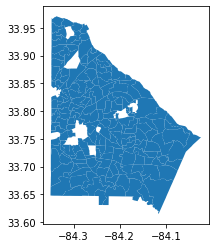

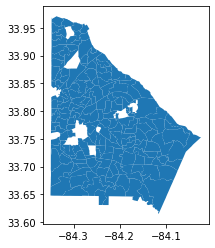

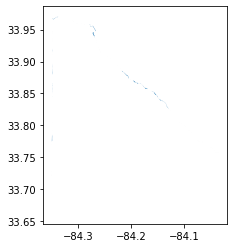

In [49]:
source_shapes.plot()
vest_shapes.plot()

shp_difference = gp.overlay(source_shapes,vest_shapes,how='symmetric_difference')
shp_difference.plot()